In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra

using FenrirForNeuro
using ModelingToolkit
using OrdinaryDiffEq

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function simulate(prob, p, proj)
    tₛ, tₑ = prob.tspan
    sol = solve(
        remake(prob, p=p),
        RadauIIA5(),
        abstol=1e-14,
        reltol=1e-14,
        dense=false,
    )
    t_obs = sol.t[1:end]
    u_obs = vcat([(proj * u) for u in sol.u]...)
    return t_obs, u_obs
end

function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)

pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end

where_converged (generic function with 2 methods)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.9 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [4]:
@parameters gNa gK
θ = [gNa => 25, gK => 7]
prob_prior, prob = get_SinglecompartmentHH(θ)

proj = [1 0 0 0]
observation = generate_data(prob, proj, 1e-1, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100.0], u = [[-69.87591637581349], [-69.82746957367105], [-70.31326762358123], [-69.68988397991959], [-69.78253257929072], [-70.28538427367918], [-70.19217601496129], [-70.13456604097621], [-70.43105234236647], [-69.95097191675862]  …  [-65.11819738729925], [-65.88967600690846], [-65.50696573449116], [-65.68939259830945], [-66.2161280466746], [-65.4738265298998], [-65.50730445699656], [-65.54980763178303], [-65.97813909034498], [-65.51872984289604]])

In [5]:
PATH = RESULTS_PATH * "hh/2p/simple/fenrir/tempered_diff/"
opt_fnames = readdir.(PATH)

trajectories = import_csvs(PATH, opt_fnames, [pkeys(θ)..., :κ², :loss, :T])

PATH = RESULTS_PATH * "hh/2p/simple/fenrir/loss_surface"
loss_surface_fnames = filter(x -> !occursin("grad", x), readdir.(PATH))
sort_fnames(fnames) = fnames[sortperm([parse(Int64, split(split(fname, "-")[end-1], "_")[end]) for fname in fnames])]
loss_surface_fnames = sort_fnames(loss_surface_fnames)

loss_surface_sections = import_csvs(PATH, loss_surface_fnames)

tempering_schedule = reverse([10.0^x for x in 0:20])
header = ["gNa", "gK", [@sprintf("κ²=%1.e", κ²) for κ² in tempering_schedule]...]

loss_surface = vcat(loss_surface_sections...)
rename!(loss_surface, header)

lb, ub = get_prior_bounds(prob_prior)

((gNa = 0.5, gK = 0.0001), (gNa = 80.0, gK = 15.0))

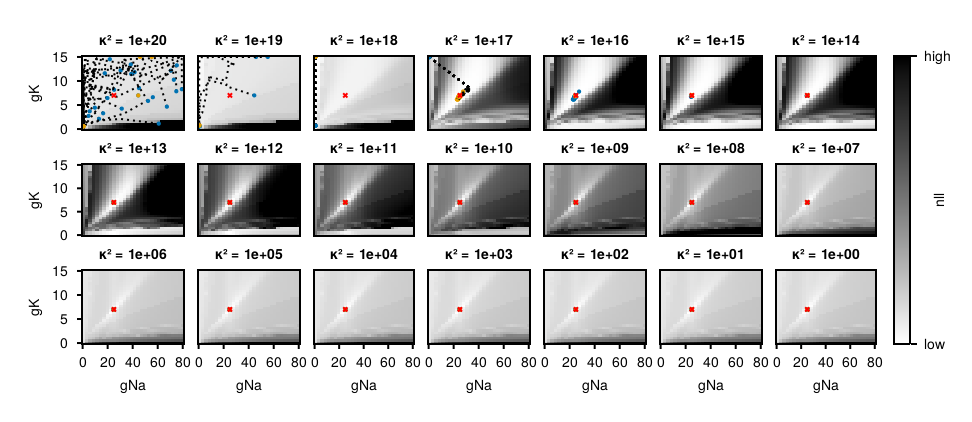

In [6]:
# import png
schematic_path = FIGURES_PATH * "hh_schematic.png"
hh_schematic = load(schematic_path)

f = Figure(size=(FULL_WIDTH, HEIGHT))
fgrid = f[1, 1] = GridLayout()

nll = reshape(Array(loss_surface[:, 3:end]), (30, 30, 21))
gNa_range = sort(unique(Array(loss_surface[:, 1])))
gK_range = sort(unique(Array(loss_surface[:, 2])))

for (i, κ²) in enumerate(tempering_schedule)
    title = @sprintf("κ² = %1.e", κ²)
    ax_c = Axis(fgrid[Int64(floor((i - 1) / 7))+1, ((i-1)%7)], xlabel="gNa", ylabel="gK", title=title; PLOT_DEFAULTS...)
    xlims!(ax_c, (-1 + lb[1], ub[1] + 1))
    ylims!(ax_c, (-0.2 + lb[2], ub[2] + 0.2))

    # prepare data
    t_at_κ² = [t[log.(t[!, :κ²]).==log.(κ²), :] for t in trajectories]

    # plot
    norm_nll = (nll[:, :, i])
    # normalize 
    norm_nll = (norm_nll .- minimum(norm_nll)) ./ (maximum(norm_nll) - minimum(norm_nll))
    heatmap!(ax_c, gNa_range, gK_range, norm_nll, colormap=reverse(cgrad(:greys)), colorrange=(0, 0.8), highclip=:black)
    for t in t_at_κ²[1:25]
        if size(t)[1] > 0
            lines!(ax_c, t[!, pkeys(θ)[1]], t[!, pkeys(θ)[2]], linewidth=1, color=:black, linestyle=:dot)
            scatter!(ax_c, t[1, pkeys(θ)[1]], t[1, pkeys(θ)[2]], color=Makie.wong_colors()[1], markersize=3)
            scatter!(ax_c, t[end, pkeys(θ)[1]], t[end, pkeys(θ)[2]], color=Makie.wong_colors()[2], markersize=3)
        end
    end

    scatter!(ax_c, pvalues(θ)..., color=:red, markersize=4, marker=:x)

    # fmt
    hidey = ((i - 1) % 7) != 0
    hidex = Int64(floor((i - 1) / 7)) + 1 != 3
    hidexdecorations!(ax_c, label=hidex, ticks=hidex, ticklabels=hidex)
    hideydecorations!(ax_c, label=hidey, ticks=hidey, ticklabels=hidey)
end

cbar = Colorbar(f[1, 2], label="nll", ticklabelsize=7, limits=(0, 1), labelsize=7, ticks=([0, 1], ["low", "high"]), size=8, ticksize=3, labelpadding=-10, colormap=reverse(cgrad(:greys)))
colgap!(f.layout, 1, Relative(0.02))
colsize!(f.layout, 1, Relative(0.99))

colgap!(fgrid, 7)
rowgap!(fgrid, 5)
f

In [7]:
save(joinpath(FIGURES_PATH, "appendix_figure4a.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}


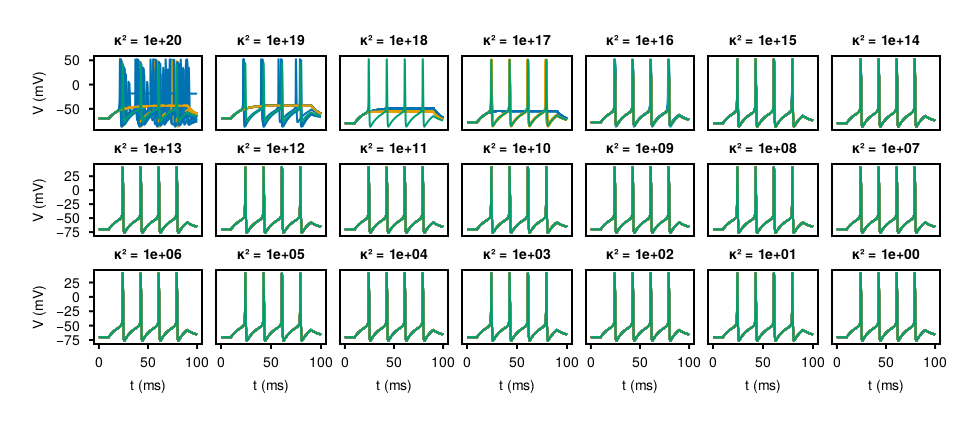

In [8]:
f = Figure(size=(FULL_WIDTH, HEIGHT))

for (i, κ²) in enumerate(tempering_schedule)
    title = @sprintf("κ² = %1.e", κ²)
    ax = Axis(f[Int64(floor((i - 1) / 7))+1, ((i-1)%7)], xlabel="t (ms)", ylabel="V (mV)", title=title; PLOT_DEFAULTS...)


    # prepare data
    t_at_κ² = [t[log.(t[!, :κ²]).==log.(κ²), :] for t in trajectories]

    # plot
    for t in t_at_κ²[1:25]
        line_cmap = :bluesreds
        if size(t)[1] > 0
            t_1st, y_1st = simulate(prob, t[1, pkeys(θ)], proj)
            t_last, y_last = simulate(prob, t[end, pkeys(θ)], proj)
            lines!(ax, t_1st, y_1st, color=Makie.wong_colors()[1], linewidth=1)
            lines!(ax, t_last, y_last, color=Makie.wong_colors()[2], linewidth=1)
        end
    end
    
    
    t_true, y_true = simulate(prob, pvalues(θ), proj)
    lines!(ax, t_true, y_true, color=Makie.wong_colors()[3], markersize=4, marker=:x, linewidth=1)

    # fmt
    hidey = ((i - 1) % 7) != 0
    hidex = Int64(floor((i - 1) / 7)) + 1 != 3
    hidexdecorations!(ax, label=hidex, ticks=hidex, ticklabels=hidex)
    hideydecorations!(ax, label=hidey, ticks=hidey, ticklabels=hidey)
end

colgap!(f.layout, 7)
rowgap!(f.layout, 5)

f

In [9]:
save(joinpath(FIGURES_PATH, "appendix_figure4b.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
